In [1]:
#Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from numpy import random

## Análisis exploratorio de datos 

In [2]:
head_names = ['age', 'job', 'marital', 'education', 'credit', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y']
df_bank = pd.read_csv('bank-full.csv', delimiter=';', header=None,names=head_names,skiprows=1)
print("Dimensión data set",df_bank.shape)
df_bank.head()

Dimensión data set (45211, 17)


,age,job,marital,education,credit,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
y = df_bank["y"]
y = y.replace("no", 0)
y = y.replace("yes", 1)
X = df_bank.drop('y', axis=1)


## Carácteristicas categóricas

En este caso se debe preprocesar aquellas carácteristicas categorical que el modelo no puede entender y convertirlas a variables númericas, a esto se le conoce como *"One Hot Encode"*. Se resuelve con la librería de sklearn o con pandas creando las variables ficticias conocidas **"Dummy variables"**.

Se debe tener en cuenta que podemos eliminar uno variable "dummy" porque si el resto de variables no son debe ser esa, esto quitará redundancia.

Este caso corresponde a las carácteristicas job,education,contact,month y las variables binarias como default, housing,loan, contact y  y.

In [36]:
df_bank.dtypes

age           int64
job          object
marital      object
education    object
credit       object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

Se selecciona las variables tipo 'object', en este caso corresponde a variables categoricas. Esto nos permite separar dichas variables para su tratamiento con el "One Hot Encoding" segmentada. 

En la siguiente celda se observa que la variable mes puede ser reemplazado por un valor númerico directamente y así mismo con las variables binarias, a esto se le conoce como "Integer encoding"

In [4]:
obj_df = df_bank.select_dtypes(include=['object']).copy()
obj_df.columns

for column in obj_df.columns:
    print(obj_df[column].value_counts(ascending=True))

Index(['job', 'marital', 'education', 'credit', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')

In [5]:
# Reemplazar el mes y variables binarias por un valor numerico
cat_var = {'month':{'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12},
          'housing': {'yes':1,'no':0},
          'credit':{'yes':1,'no':0},
          'loan' : {'yes':1,'no':0},
          'y':{'yes':1,'no':0}
         }
obj_df.replace(cat_var, inplace=True)

#for i in range(df_bank.shape[0]):
#    df_bank.at[i, 'month'] = months[df_bank.at[i, 'month']]

In [224]:
obj_df.head()

,job,marital,education,credit,housing,loan,contact,month,poutcome,y
0,management,married,tertiary,0,1,0,unknown,5,unknown,0
1,technician,single,secondary,0,1,0,unknown,5,unknown,0
2,entrepreneur,married,secondary,0,1,1,unknown,5,unknown,0
3,blue-collar,married,unknown,0,1,0,unknown,5,unknown,0
4,unknown,single,unknown,0,0,0,unknown,5,unknown,0


### One hot Encode job

Ahora bien, aún nos falta 5 variables por aplicar los valores númericos con más de 2 categorías. Tenemos 'job' con 12 categorías, 'marital' con 3, 'education' con 4, 'contact' con 3, por último 'poutcome' con 4.

Hay que tener en cuenta que existe una trampa de la variables ficticias creadas y consiste en crear una nueva variable por cada una, llega a ser redundante. Por tanto la solución está eliminar una de las variables categóricas, si hay $d$ número de categorías, use $d-1$ en el modelo, el valor omitido se puede considerar como el valor de referencia y los valores nuevos de las categorías restantes representan el cambio de esta referencia.

Dicho lo anterior se resta una categoría a cada variable y las otras 5 variables de categorías enteras esperamos 26 variables, el DataFrame resultante se guarda en **obj_df**

In [6]:
cols_dummies = ['job', 'marital', 'education', 'contact', 'poutcome']
obj_df = pd.get_dummies(obj_df,prefix=cols_dummies, drop_first=True)
len(obj_df.columns)

26

In [8]:
#Nombre de las variables categoricas
cat_vars = cols_dummies + list(cat_var.keys())

Nos disponemos a concatenar las variables tipo enteras con las categóricas.

In [14]:
index = ['age','housing', 'loan', 'job_blue-collar','job_entrepreneur', 'job_housemaid', 'job_management', 
         'job_retired','job_self-employed', 'job_services', 'job_student', 'job_technician','job_unemployed',
         'job_unknown', 'marital_married', 'marital_single','education_secondary', 'education_tertiary', 
         'education_unknown','day', 'month','contact_telephone', 'contact_unknown',  'balance',  'duration', 
         'campaign', 'pdays', 'previous','credit','poutcome_other','poutcome_success', 'poutcome_unknown', 'y']

df_bank_copy = df_bank.copy()
df_bank_copy = df_bank_copy.drop(columns=cat_vars)
df_bank_copy.head()
df_bank_2 = pd.concat([obj_df.T, df_bank_copy.T]).T
df_bank_2 = df_bank_2[index]



(45211, 33)

## Imbalanced Classes 

Una vez ya tenemos las variables categoricas listas para entrenar, surge otra cuestión. Contamos con un dataset desbalanceado, la clase positiva (el usuario que se suscribió a la campaña) representa un 13% en comparación de la clase negativa. 

Como primera instancia, vamos a aplicar la técnica de SMOTE para hacer pruebas sintenticas y tratar de mejorar ese porcentaje. No buscamos igualarlo pero si mejorar la situación de desbalanceo al menos un poco.

0    39922
1     5289
Name: y, dtype: int64

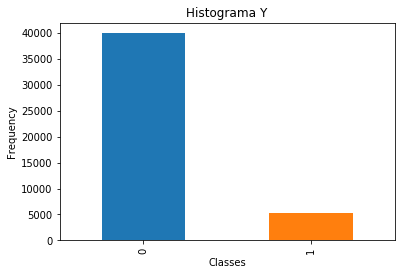

In [10]:
pd.value_counts(df_bank_2['y']).plot.bar()
plt.title('Histograma Y')
plt.xlabel('Classes')
plt.ylabel('Frequency')
df_bank_2['y'].value_counts()

In [16]:
index = ['age','housing', 'loan', 'job_blue-collar','job_entrepreneur', 'job_housemaid', 'job_management', 
         'job_retired','job_self-employed', 'job_services', 'job_student', 'job_technician','job_unemployed',
         'job_unknown', 'marital_married', 'marital_single','education_secondary', 'education_tertiary', 
         'education_unknown','day', 'month','contact_telephone', 'contact_unknown',  'balance',  'duration', 
         'campaign', 'pdays', 'previous','credit','poutcome_other','poutcome_success', 'poutcome_unknown']

X_full = df_bank_2[index]
y_full = df_bank_2['y']

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (31647, 32)
Number transactions y_train dataset:  (31647,)
Number transactions X_test dataset:  (13564, 32)
Number transactions y_test dataset:  (13564,)


In [17]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy=0.16,random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 3694
Before OverSampling, counts of label '0': 27953 

After OverSampling, the shape of train_X: (32425, 32)
After OverSampling, the shape of train_y: (32425,) 

After OverSampling, counts of label '1': 4472
After OverSampling, counts of label '0': 27953


## Missing data

En nuestro análisis exploratorio, debemos lidiar con los valores faltantes. Al parecer en nuestro caso no hay, sin embargo muchas veces esos valores pueden de diferente formas tales como 0, signos de interrogación o números negativos (según su interpretación). Es así que decidimos ir más allá.

In [46]:
df_bank.info()
df_bank.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
credit       45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


age          0
job          0
marital      0
education    0
credit       0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

# ---- REVISAR PREVIUOS -1

## Scale data

With describe() tell me the huge diference between features

## Entrenamiento

In [232]:
X = df_bank_2[index].values
Y = df_bank_2['y'].values

kNN()

/home/deiry/py3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/deiry/py3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/deiry/py3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/deiry/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/home/deiry/py3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/home/deiry/py3/lib/pyth

Eficiencia durante el entrenamiento = 0.0+-0.0
Eficiencia durante la validación = 0.0+-0.0


/home/deiry/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
/home/deiry/py3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [215]:
def trainModel():
    
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:]
        Ytrain = Y[train]
        Xtest = X[test,:]
        Ytest = Y[test]

        #Normalizamos los datos
        media = np.mean(Xtrain)
        desvia = np.std(Xtrain)
        Xtrain = sc.stats.stats.zscore(Xtrain)
        Xtest = (Xtest - np.matlib.repmat(media, Xtest.shape[0], 1))/np.matlib.repmat(desvia, Xtest.shape[0], 1)

## Naïve Bayes

In [42]:
def naiveBayes():
    pass

## K vecinos más cercanos

In [231]:
def kNN(neighbors=5):
    Folds = 4
    random.seed(19680801)
    EficienciaTrain = np.zeros(Folds)
    EficienciaVal = np.zeros(Folds)
    skf = StratifiedKFold(n_splits=Folds)
    j = 0
    
    
    for train, test in skf.split(X, Y):
        Xtrain = X[train,:]
        Ytrain = Y[train]
        Xtest = X[test,:]
        Ytest = Y[test]

        #Normalizamos los datos
        scaler = preprocessing.StandardScaler().fit(Xtrain)
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        
        # creamos el clasificador
        classifier = KNeighborsClassifier(n_neighbors=neighbors)  
        classifier.fit(Xtrain, Ytrain)
        
        y_pred = classifier.predict(X_test)
        
        #Evaluamos las predicciones del modelo con los datos de test
        EficienciaTrain[j] = np.mean(y_pred.ravel() == Ytrain.ravel())
        EficienciaVal[j] = np.mean(y_pred.ravel() == Ytest.ravel())
        j += 1
        
    print('Eficiencia durante el entrenamiento = ' + str(np.mean(EficienciaTrain)) + '+-' + str(np.std(EficienciaTrain)))
    print('Eficiencia durante la validación = ' + str(np.mean(EficienciaVal)) + '+-' + str(np.std(EficienciaVal)))

## Redes Neuronales Artificiales

In [43]:
def neuralNetwork():
    pass

## Random Forest

In [45]:
def randomForest():
    pass

## Máuinas de Soporte Vectorial con kernel lineal y con kernel RBF.

In [47]:
# lineal kernel and rbf kernel
def SVM():
    pass

### Tener en cuenta

In [63]:
df_bank['job'].describe()

count           4521
unique            12
top       management
freq             969
Name: job, dtype: object

In [73]:
df_bank[df_bank['pdays'] == -1].shape

(36954, 17)

In [ ]:
out = df_bank["y"]
out = out.replace("no", 0)
out = out.replace("yes", 1)
x = df_bank["education"]
y = df_bank["job"]

#_ = sns.swarmplot(x='duration', y='age', data=df_bank)
#plt.hist(y)
# Label the axes
plt.title('Age vs housing', fontsize=14)
plt.xlabel('Edad')
plt.ylabel('duration')
plt.scatter(x,y,c=out,cmap="Accent")
plt.show()

In [ ]:
sns.set(style="whitegrid")
ax = sns.swarmplot(x="housing", y="age", data=df_bank)

In [34]:

#print("Tipos datos", df_bank.dtypes)
df_bank[df_bank['poutcome'] != 'unknown']
df_success = df_bank[df_bank['y'] == 'yes']
df_no_success = df_bank[df_bank['y'] == 'no']

print("Muestras de exito ",df_success.shape, "Muestras de no éxito",df_no_success.shape)

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

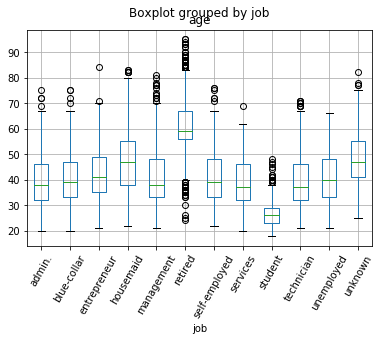

In [17]:
df_bank.boxplot('age','job',rot=60)
plt.show()